<a href="https://colab.research.google.com/github/lucrilhos/analise-de-dados-do-ONS/blob/main/cp_analise_de_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise de dados do ONS**



*   Lucas M. - 563667
*   Rodrigo C. - 566386
*   Pedro N. - 564572
*   Gabriel B. - 563247
*   João Pedro - 565031



## **Exercício 1**

Tipos de geração encontrados: ['HIDROELÉTRICA' 'TÉRMICA' 'EOLIELÉTRICA' 'NUCLEAR' 'FOTOVOLTAICA']


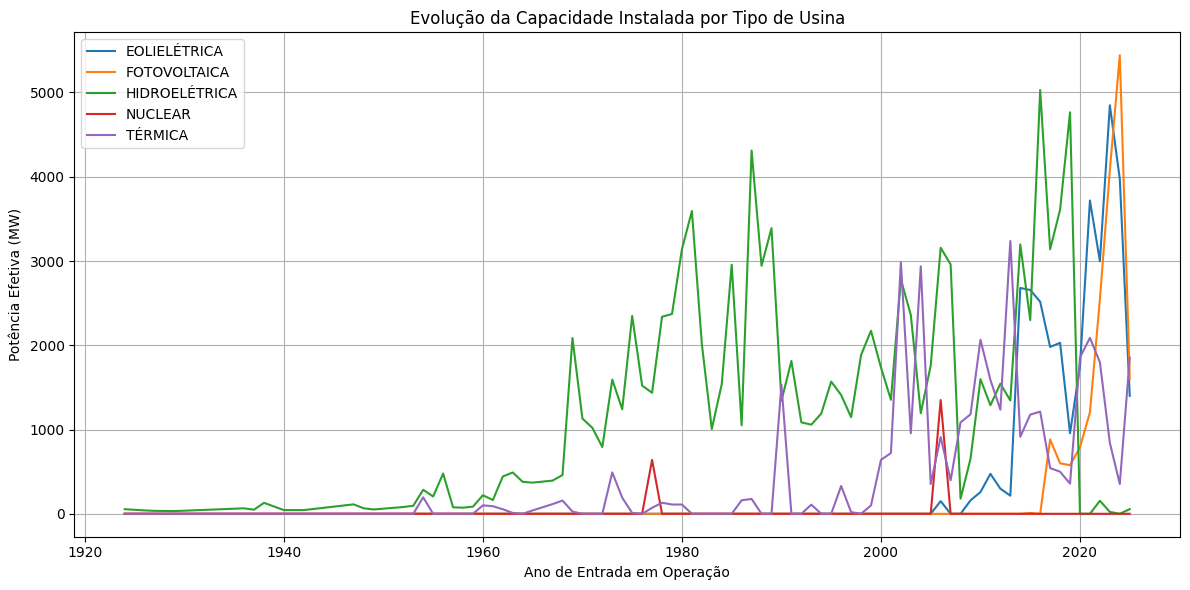


Crescimento nos últimos 10 anos (MW):
nom_tipousina
FOTOVOLTAICA     1593.3152
TÉRMICA           677.7190
NUCLEAR             0.0000
EOLIELÉTRICA    -1255.9750
HIDROELÉTRICA   -2243.8300
dtype: float64


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# carregamento do dataset
df = pd.read_csv("CAPACIDADE_GERACAO.csv", sep=";", parse_dates=["dat_entradaoperacao"])


tipos_geracao = df["nom_tipousina"].unique()
print("Tipos de geração encontrados:", tipos_geracao) # exibe os tipos de geração

# criação de coluna separada por ano de operação
df["ano_operacao"] = df["dat_entradaoperacao"].dt.year

df_filtrado = df.dropna(subset=["ano_operacao", "val_potenciaefetiva"]) # remover as linhas sem data de operação

# Agrupar por tipo de usina e ano, somando a potência efetiva
evolucao = df_filtrado.groupby(["ano_operacao", "nom_tipousina"])["val_potenciaefetiva"].sum().reset_index()

# pivotação do gráfico, porque isso facilita a exibição e entendimento do gráfico
evolucao_pivot = evolucao.pivot(index="ano_operacao", columns="nom_tipousina", values="val_potenciaefetiva").fillna(0)

plt.figure(figsize=(12, 6)) # plot do gráfico com a linha de evolução
for tipo in evolucao_pivot.columns:
    plt.plot(evolucao_pivot.index, evolucao_pivot[tipo], label=tipo)

plt.title("Evolução da Capacidade Instalada por Tipo de Usina")
plt.xlabel("Ano de Entrada em Operação")
plt.ylabel("Potência Efetiva (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# com base nos dados, analisar qual linha foi a mais crescente nos últimos 10 anos
recente = evolucao_pivot.loc[evolucao_pivot.index >= evolucao_pivot.index.max() - 10]
crescimento = recente.diff().sum().sort_values(ascending=False)
print("\nCrescimento nos últimos 10 anos (MW):")
print(crescimento)


## **Exercício 2**

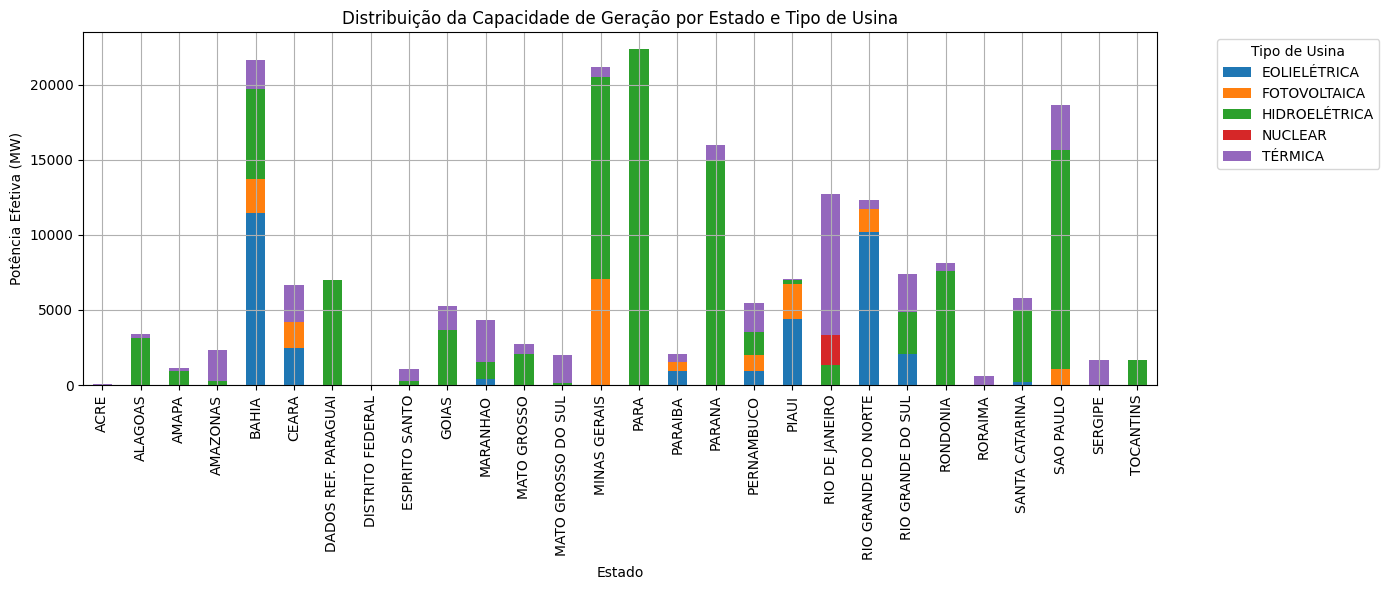


Participação percentual de cada fonte por estado:
nom_tipousina        EOLIELÉTRICA  FOTOVOLTAICA  HIDROELÉTRICA  NUCLEAR  \
nom_estado                                                                
ACRE                         0.00          0.00           0.00     0.00   
ALAGOAS                      0.00          0.00          93.80     0.00   
AMAPA                        0.00          0.00          82.60     0.00   
AMAZONAS                     0.00          0.00          10.81     0.00   
BAHIA                       52.77         10.71          27.50     0.00   
CEARA                       36.60         26.22           0.00     0.00   
DADOS REF. PARAGUAI          0.00          0.00         100.00     0.00   
DISTRITO FEDERAL             0.00          0.00           0.00     0.00   
ESPIRITO SANTO               0.00          0.00          26.59     0.00   
GOIAS                        0.00          0.00          69.91     0.00   
MARANHAO                     9.80          0.00  

KeyError: 'SOLAR'

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("CAPACIDADE_GERACAO.csv", sep=";")

# agrupa os dados em dois tipos: estado e tipo de geração, conseguinte da potência ativa
agrupado = df.groupby(["nom_estado", "nom_tipousina"])["val_potenciaefetiva"].sum().reset_index()

# em sequência tem uma série de linhas que gera um gráfico separado por estados
pivot = agrupado.pivot(index="nom_estado", columns="nom_tipousina", values="val_potenciaefetiva").fillna(0)
pivot.plot(kind="bar", stacked=True, figsize=(14, 6))
plt.title("Distribuição da Capacidade de Geração por Estado e Tipo de Usina")
plt.xlabel("Estado")
plt.ylabel("Potência Efetiva (MW)")
plt.legend(title="Tipo de Usina", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.grid(True)
plt.show()

# porcentagem da participação de cada estado
percentual = pivot.div(pivot.sum(axis=1), axis=0) * 100
print("\nParticipação percentual de cada fonte por estado:")
print(percentual.round(2))

# identificar os estados líderes no uso de energia solar e eólica, para em seguida exibir isso
solar_lideres = percentual["SOLAR"].sort_values(ascending=False).head()
eolica_lideres = percentual["EÓLICA"].sort_values(ascending=False).head()

print("\nEstados líderes em energia solar:")
print(solar_lideres)

print("\nEstados líderes em energia eólica:")
print(eolica_lideres)

## **Exercício 3**

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# filtragem dos datasets apenas para usinas solares
df = pd.read_csv("CAPACIDADE_GERACAO.csv", sep=";", parse_dates=["dat_entradaoperacao"])
df_solar = df[df["nom_tipousina"] == "SOLAR"].dropna(subset=["dat_entradaoperacao", "val_potenciaefetiva"])

# série temporal para segmentar os anos de operação
df_solar["ano_operacao"] = df_solar["dat_entradaoperacao"].dt.year
serie = df_solar.groupby("ano_operacao")["val_potenciaefetiva"].sum().reset_index()


X = serie["ano_operacao"].values.reshape(-1, 1)
y = serie["val_potenciaefetiva"].values # regressão de dados x e y

lr = LinearRegression()
rf = RandomForestRegressor(random_state=42)

lr.fit(X, y)
rf.fit(X, y)

# previsões para os próximos 5 anos
anos_futuros = np.array(range(X.max() + 1, X.max() + 6)).reshape(-1, 1)
lr_pred = lr.predict(anos_futuros)
rf_pred = rf.predict(anos_futuros)

#´plotagem do gráfico com todas as informações
plt.figure(figsize=(10, 6))
plt.plot(X, y, label="Histórico", marker="o")
plt.plot(anos_futuros, lr_pred, label="Linear Regression", linestyle="--")
plt.plot(anos_futuros, rf_pred)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.

# **Exercício 4**

Acurácia do modelo: 0.9641975308641976

Relatório de classificação:
               precision    recall  f1-score   support

 EOLIELÉTRICA       0.98      0.98      0.98       609
 FOTOVOLTAICA       0.94      0.96      0.95       309
HIDROELÉTRICA       0.96      0.94      0.95       237
      NUCLEAR       0.00      0.00      0.00         1
      TÉRMICA       0.96      0.97      0.96       464

     accuracy                           0.96      1620
    macro avg       0.77      0.77      0.77      1620
 weighted avg       0.96      0.96      0.96      1620


Variáveis mais influentes na classificação:
val_potenciaefetiva               0.361774
ano_operacao                      0.337338
nom_estado_MINAS GERAIS           0.062850
nom_estado_RIO GRANDE DO NORTE    0.030298
nom_estado_BAHIA                  0.026882
nom_estado_SAO PAULO              0.021934
nom_estado_RONDONIA               0.018650
nom_estado_RIO DE JANEIRO         0.015120
nom_estado_CEARA                  0.012827
no

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


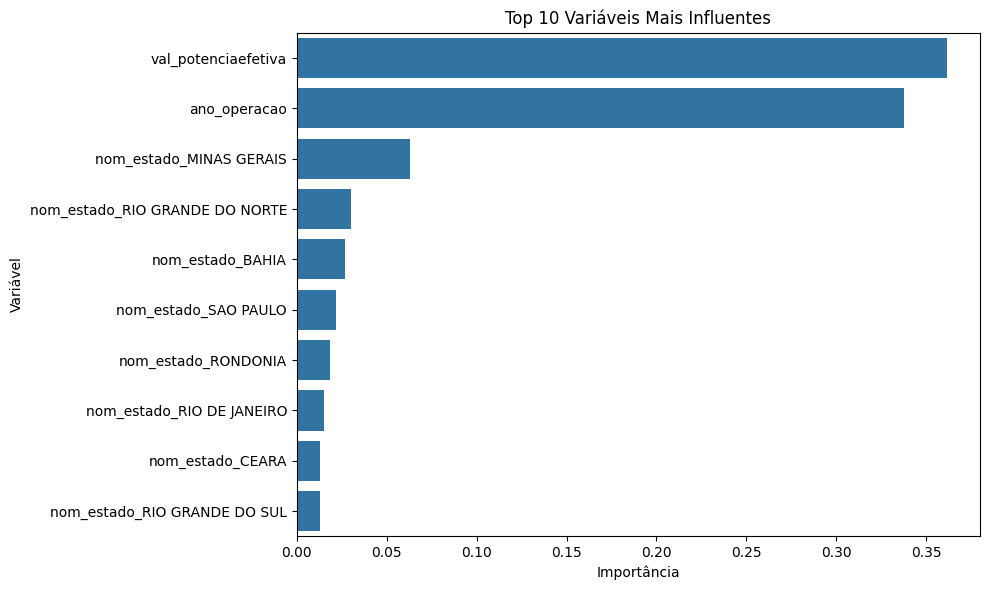

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_csv("CAPACIDADE_GERACAO.csv", sep=";", parse_dates=["dat_entradaoperacao"])

# separação de variáveis iguais a dos outros blocos
df_modelo = df[["val_potenciaefetiva", "nom_estado", "dat_entradaoperacao", "nom_tipousina"]].dropna()

df_modelo["ano_operacao"] = df_modelo["dat_entradaoperacao"].dt.year

# codifica as variáveis categóricas
df_modelo_encoded = pd.get_dummies(df_modelo[["val_potenciaefetiva", "nom_estado", "ano_operacao"]])

# Variável alvo
y = df_modelo["nom_tipousina"]

# separar os dados x e y entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(df_modelo_encoded, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test) # treino do modelo de classificação

# avalia a acurácia/capacidade do modelo
print("Acurácia do modelo:", accuracy_score(y_test, y_pred))
print("\nRelatório de classificação:")
print(classification_report(y_test, y_pred))

# peso das variáveis
importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nVariáveis mais influentes na classificação:")
print(importances.head(10))

# plotagem das importâncias e variáveis mais influentes
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.head(10), y=importances.head(10).index)
plt.title("Top 10 Variáveis Mais Influentes")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()


# **Exercício 5**

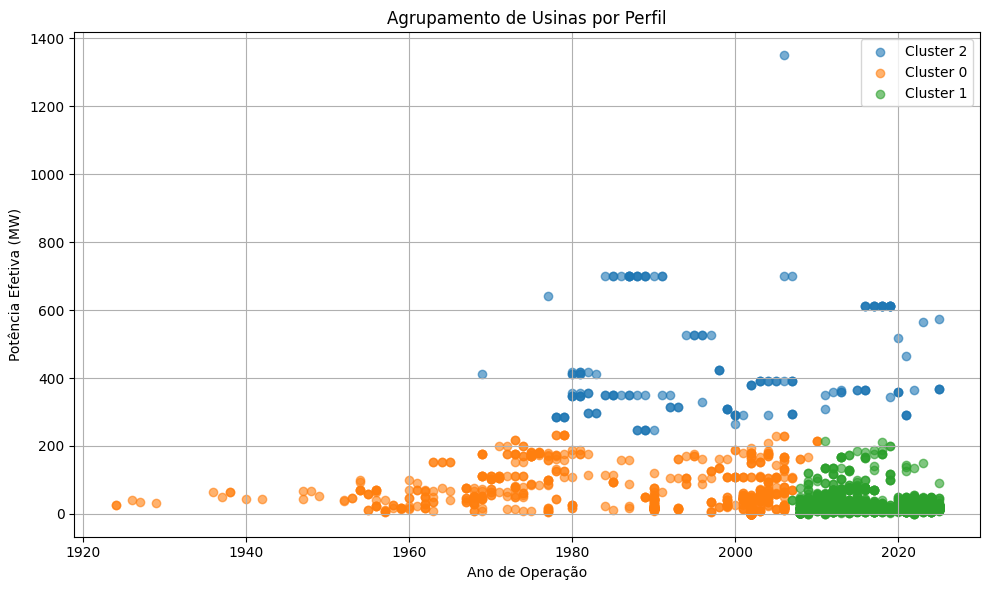


Perfil médio de cada cluster:
         val_potenciaefetiva  ano_operacao
cluster                                   
0                      37.98       1994.14
1                      20.84       2018.77
2                     439.74       1998.53


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# preparação e carregamento dos dados
df = pd.read_csv("CAPACIDADE_GERACAO.csv", sep=";", parse_dates=["dat_entradaoperacao"])
df_cluster = df[["val_potenciaefetiva", "dat_entradaoperacao", "nom_tipousina"]].dropna()

# organização de coluna por ano
df_cluster["ano_operacao"] = df_cluster["dat_entradaoperacao"].dt.year

# variáveis numéricas
X = df_cluster[["val_potenciaefetiva", "ano_operacao"]]

# padronização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# aplicação k-means
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster["cluster"] = kmeans.fit_predict(X_scaled)

# visualização dos clusters
plt.figure(figsize=(10, 6))
for cluster in df_cluster["cluster"].unique():
    grupo = df_cluster[df_cluster["cluster"] == cluster]
    plt.scatter(grupo["ano_operacao"], grupo["val_potenciaefetiva"], label=f"Cluster {cluster}", alpha=0.6)

plt.title("Agrupamento de Usinas por Perfil")
plt.xlabel("Ano de Operação")
plt.ylabel("Potência Efetiva (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# exibição do perfil de cada cluster
print("\nPerfil médio de cada cluster:")
print(df_cluster.groupby("cluster")[["val_potenciaefetiva", "ano_operacao"]].mean().round(2))
